In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [3]:
returns = pd.read_pickle('/Users/nishb/Documents/IX/Internship/returns.pkl')
returns = returns.iloc[1:]
returns

,905270,921795,904261,905261,916328,923024,936365,902355,912215,929813,...,9660J1,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
1990-01-03,-0.835165,-0.475059,5.000000,-0.810537,0.361421,0.000000,-3.030303,0.000000,-0.431034,-1.315789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,-0.797872,-1.272872,2.380952,-1.634321,-0.180060,3.454545,-1.562500,0.530612,0.225108,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,-2.546917,1.531023,-0.372093,-1.661475,-1.079730,1.054482,-3.174603,0.487211,-0.656531,-1.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,2.017423,-0.873016,0.000000,2.534319,0.000000,0.000000,0.000000,1.010101,0.434783,3.405405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-09,-1.123596,-2.962370,-0.404606,-1.098524,-0.364707,-1.043478,1.639344,0.000000,0.432900,-3.293257,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#for stock in ret.columns:
 #   ret.replace([np.inf, -np.inf], np.nan, inplace=True)
  #  ret[stock] = ret[stock].fillna(0)

In [4]:
drop_columns = []

for col in returns.columns:
    if returns[col].isnull().all() == True:
        drop_columns.append(col)
        
returns.drop(columns=drop_columns, inplace=True)

In [5]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = returns.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [6]:
def format_investable(df, n_in=1, n_out=1):
    "Takes investable dataframe and formats it to have all stock returns at time t-1\
    (the features) and all corresponding stock returns at time t (the targets)\
    n_in is the number of past returns we want to use, n_out is the number of future \
    returns we want to predict"
    
    n_vars = df.shape[1]
    
    cols = []
    input_col_names = df.add_suffix(' (t-1)').columns
    forecast_col_names = df.add_suffix(' (t)').columns
    names = input_col_names.append(forecast_col_names)
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(-i))

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(i))
        
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop the first row (it contains NaNs)
    agg.dropna(inplace=True)
    
    return agg

In [7]:
t = pd.to_datetime("2020-02-25")

investable = get_investable(t, 80)
#format as features and targets
f_investable = format_investable(investable)
f_investable

,916328 (t-1),936365 (t-1),905271 (t-1),905113 (t-1),905802 (t-1),905425 (t-1),906156 (t-1),916305 (t-1),992816 (t-1),921093 (t-1),...,311917 (t),69568X (t),543755 (t),77463M (t),29235J (t),131745 (t),69487D (t),68157P (t),9110RA (t),292703 (t)
date,,,,,,,,,,,,,,,,,,,,,
2020-02-25,-3.224700,-7.807808,-3.702396,-1.195098,-6.519714,-1.641923,-4.974055,-5.967078,-4.750040,-2.460137,...,-3.143786,-4.063373,-3.230178,-7.889975,-0.801833,-10.767947,-2.595937,-4.850151,-11.700270,-3.014745
2020-02-24,-1.141759,-6.966998,-0.168363,-0.682511,-0.463535,-0.654425,-1.230048,-2.409639,-2.263503,-0.746100,...,-2.020070,-7.459489,-2.467504,-6.481638,-6.091830,-4.945782,-4.950192,-2.934848,-7.530828,-3.530293
2020-02-21,-1.007162,-2.767402,-0.164178,-1.085978,1.809029,-1.082126,-0.255605,0.789314,-1.025895,0.591312,...,-1.364204,0.176838,-1.604162,0.595846,-4.036727,-0.943149,-3.189911,-0.666838,-1.943285,-1.020350
2020-02-20,0.540054,3.533134,0.031282,2.682395,3.974485,-0.795553,0.980826,0.816160,1.448276,-1.079865,...,-0.471153,-1.963115,0.348053,2.656414,-1.813720,2.884097,-0.111152,0.610700,0.028798,-1.631715
2020-02-19,-0.869953,2.856626,-0.105465,-0.539684,1.325820,0.549345,-0.198719,1.093234,-1.831051,-0.714764,...,-1.072034,6.875586,0.767207,42.444610,1.149301,0.487541,0.806753,4.644464,0.915432,1.375625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-06,0.145950,-0.385781,1.007369,2.536276,0.664356,-1.508621,-0.710584,-0.218460,-0.143689,-0.209011,...,1.393274,2.950634,-2.074183,-2.097902,-1.494649,-1.406534,-1.845609,-0.747863,1.624783,-1.401547
2019-11-05,-0.532301,4.012611,0.402697,0.841108,0.478886,-0.812313,0.402887,2.176339,0.656712,1.484798,...,-2.116804,-0.078748,-0.413123,3.536619,0.918684,1.100917,0.661690,0.504671,-1.451751,-0.978310
2019-11-04,-1.136228,2.829355,0.140673,3.894889,4.806084,-0.879330,1.585948,1.510574,2.838077,0.927688,...,-1.623956,1.327758,0.808427,-4.646840,3.548014,1.655398,-0.101695,1.448802,1.693443,-0.647981


In [8]:
ret = f_investable.iloc[:, 0:525]
ret

,916328 (t-1),936365 (t-1),905271 (t-1),905113 (t-1),905802 (t-1),905425 (t-1),906156 (t-1),916305 (t-1),992816 (t-1),921093 (t-1),...,311917 (t-1),69568X (t-1),543755 (t-1),77463M (t-1),29235J (t-1),131745 (t-1),69487D (t-1),68157P (t-1),9110RA (t-1),292703 (t-1)
date,,,,,,,,,,,,,,,,,,,,,
2020-02-25,-3.224700,-7.807808,-3.702396,-1.195098,-6.519714,-1.641923,-4.974055,-5.967078,-4.750040,-2.460137,...,-2.020070,-7.459489,-2.467504,-6.481638,-6.091830,-4.945782,-4.950192,-2.934848,-7.530828,-3.530293
2020-02-24,-1.141759,-6.966998,-0.168363,-0.682511,-0.463535,-0.654425,-1.230048,-2.409639,-2.263503,-0.746100,...,-1.364204,0.176838,-1.604162,0.595846,-4.036727,-0.943149,-3.189911,-0.666838,-1.943285,-1.020350
2020-02-21,-1.007162,-2.767402,-0.164178,-1.085978,1.809029,-1.082126,-0.255605,0.789314,-1.025895,0.591312,...,-0.471153,-1.963115,0.348053,2.656414,-1.813720,2.884097,-0.111152,0.610700,0.028798,-1.631715
2020-02-20,0.540054,3.533134,0.031282,2.682395,3.974485,-0.795553,0.980826,0.816160,1.448276,-1.079865,...,-1.072034,6.875586,0.767207,42.444610,1.149301,0.487541,0.806753,4.644464,0.915432,1.375625
2020-02-19,-0.869953,2.856626,-0.105465,-0.539684,1.325820,0.549345,-0.198719,1.093234,-1.831051,-0.714764,...,1.049026,7.295914,0.573192,-2.238988,-3.065014,0.135612,-2.341698,-1.907116,-0.159582,-0.317316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-06,0.145950,-0.385781,1.007369,2.536276,0.664356,-1.508621,-0.710584,-0.218460,-0.143689,-0.209011,...,-2.116804,-0.078748,-0.413123,3.536619,0.918684,1.100917,0.661690,0.504671,-1.451751,-0.978310
2019-11-05,-0.532301,4.012611,0.402697,0.841108,0.478886,-0.812313,0.402887,2.176339,0.656712,1.484798,...,-1.623956,1.327758,0.808427,-4.646840,3.548014,1.655398,-0.101695,1.448802,1.693443,-0.647981
2019-11-04,-1.136228,2.829355,0.140673,3.894889,4.806084,-0.879330,1.585948,1.510574,2.838077,0.927688,...,-0.091610,-0.511083,2.459839,-3.088008,3.775347,0.609899,3.800141,-4.949265,2.881394,2.108017


In [9]:
ret = StandardScaler().fit_transform(ret)
ret

array([[-3.41672018, -3.21246541, -3.09658788, ..., -1.66796335,
        -4.13434932, -2.44054454],
       [-1.22490766, -2.88880058, -0.2628859 , ..., -0.49276994,
        -1.23941658, -0.84546061],
       [-1.08327556, -1.27218976, -0.2595299 , ...,  0.16919968,
        -0.21767119, -1.23398664],
       ...,
       [-1.21908728,  0.88225027, -0.01509027, ..., -2.71175454,
         1.26027246,  1.1426356 ],
       [-0.5244914 ,  0.72264283, -1.4116768 , ...,  2.03901941,
         0.25806023, -1.43390021],
       [ 0.68266476, -0.09034996, -0.5291342 , ...,  0.54401738,
        -0.83302485, -0.12983353]])

In [14]:
pca = PCA(n_components=5)

In [15]:
principalComponents = pca.fit_transform(ret)

In [16]:
principalDf = pd.DataFrame(data = principalComponents)
principalDf

,0,1,2,3,4
0,51.997780,11.903588,-0.101780,-2.479171,-5.497169
1,15.813068,2.462253,7.897304,-2.429065,-3.056502
2,1.737170,3.432533,13.678221,-7.687904,-8.157025
3,-7.867002,7.912076,-7.867820,3.109451,5.172830
4,8.668594,-0.841347,1.950344,-3.238517,2.796526
...,...,...,...,...,...
74,-1.745719,15.429043,1.466495,3.514505,-9.570059
75,-12.808027,21.853319,1.766390,-3.473566,1.787778
76,-22.454315,9.938243,1.277562,-5.449602,-0.437794
77,11.308143,1.589339,0.660978,6.450705,10.388484


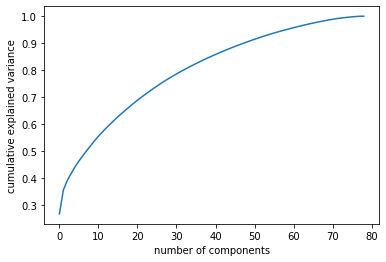

In [19]:
pca = PCA().fit(ret.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');